In [1]:
# This is a notebook to test out the implementation of adsorption correction correlations
# using uncertainties for a cpox mechanism

In [1]:
import os
import sys
import pickle
import copy
import numpy as np
import rmgpy.chemkin
import rmgpy.tools.uncertainty
import rmgpy.kinetics.uncertainties

import rmgpy.tools.canteramodel
import random

import rmgpy.kinetics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the model

# Must use annotated chemkin file
chemkin_file = '/home/moon/uncertainty_estimator/beef/cpox_Pt/chem_annotated-gas.inp'
mech_dir = os.path.dirname(chemkin_file)
dict_file = '/home/moon/uncertainty_estimator/beef/cpox_Pt/species_dictionary.txt'
surface = '/home/moon/uncertainty_estimator/beef/cpox_Pt/chem_annotated-surface.inp'

# uncertainty = rmgpy.tools.uncertainty.Uncertainty(output_directory=os.path.join(mech_dir, 'rmg_uncertainty'))


# Run Gao estimation of input parameters (takes a long time to load database)
uncertainty = rmgpy.tools.uncertainty.Uncertainty(
    output_directory='uncertainty_calculations',
    beef_data_path='/home/moon/uncertainty_estimator/beef/beef_species_ensembles.npy'
)
uncertainty.load_model(chemkin_file, dict_file, surface_path=surface)

In [3]:
# --------------- CAUTION!!! Databases here must match the ones used to generate the mechanism
thermo_libs = [
    'surfaceThermoPt111',
    'primaryThermoLibrary',
    'thermo_DFT_CCSDTF12_BAC',
    'DFT_QCI_thermo'
]
kinetic_libs = [
    'Surface/CPOX_Pt/Deutschmann2006_adjusted',
    'BurkeH2O2inArHe'
]

kinetics_families = [
    'default',
    'Surface_Adsorption_Single',
    'Surface_Adsorption_vdW',
    'Surface_Adsorption_Dissociative',
    'Surface_Dissociation',
    'Surface_Abstraction',
    'Surface_Dissociation_Double_vdW',
    'Surface_Dissociation_vdW',
    'Surface_Abstraction_vdW',
    'Surface_Dissociation_Beta',
    'Surface_Adsorption_Bidentate',
    'Surface_Bidentate_Dissociation',
    'Surface_Monodentate_to_Bidentate',
    'Surface_Dissociation_to_Bidentate', 
    'Surface_vdW_to_Bidentate',
    'Surface_Adsorption_Dissociative_Double',
    'Surface_Abstraction_Beta',
    # 'Surface_Abstraction_Beta_double_vdW',
    'Surface_Dissociation_Double',
    'Surface_Dissociation_Beta_vdW',
    'Surface_Abstraction_Beta_vdW',
    'Surface_Abstraction_Single_vdW',
]


In [4]:
uncertainty.load_database(
    thermo_libraries=thermo_libs,
    kinetics_families=kinetics_families,
    reaction_libraries=kinetic_libs,
)

ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.2599,68.0494,74.7775,80.9311,90.8846,97.4337,105.393],'J/(mol*K)'), H298=(-477.191,'kJ/mol'), S298=(269.551,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(103.931,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)(Cds-Cd)) + group(O2s-(Cds-O2d)H) + group(Cds-OdOsOs) + group(Li-OCOdO) + radical(OC=OOJ)""").
The thermo for this species is probably wrong! Setting CpInf = Cphigh for Entropy calculationat T = 2000.0 K...
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.2599,68.0494,74.7775,80.9311,90.8846,97.4337,105.393],'J/(mol*K)'), H298=(-477.191,'kJ/mol'), S298=(269.551,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(103.931,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)(Cds-Cd)) + group(O2s-(Cds-O2d)H) + group(Cds-OdOsOs) + group(Li-OCOdO) + radical(OC=OOJ)""").
The thermo for this species is probably wrong! Setting CpInf = Cphigh for En

# uncorrelated

In [5]:
# Get the different kinetic and thermo sources
uncertainty.extract_sources_from_model()
uncertainty.assign_parameter_uncertainties()

In [ ]:
np.save(os.path.join(mech_dir, 'gao_reaction_uncertainty.npy'), uncertainty.kinetic_input_uncertainties)
np.save(os.path.join(mech_dir, 'gao_species_uncertainty.npy'), uncertainty.thermo_input_uncertainties)

# correlated

In [7]:
uncertainty.extract_sources_from_model()
uncertainty.assign_parameter_uncertainties(correlated=True)

In [8]:
np.load(uncertainty.beef_data_path)

array([[-16.61648651,  -8.34199769, -16.5161484 , ..., -15.2528929 ,
         -8.06569449,   9.19191319],
       [ -9.55137522,   0.37394959, -13.44993014, ..., -11.71169724,
        -11.22794983,   4.47976971],
       [ -3.76492539,  -0.38457234,  -4.42576486, ..., -14.87374565,
         -0.9227891 ,  11.76643186],
       ...,
       [ -6.52203129,  -3.71266297, -15.67577621, ..., -36.28228046,
        -20.56724035,  29.60562998],
       [ 13.26175113,   0.54883672,  -2.24214106, ..., -16.28502475,
        -13.1762392 ,  -3.43706725],
       [ 19.62622931,  -1.92722022,   1.1329458 , ...,  -5.62672745,
        -12.50772   , -11.67878948]])

In [9]:
cov_thermo = uncertainty.get_thermo_covariance_matrix()

Text(0, 0.5, 'Surface Species                    Gas Species')

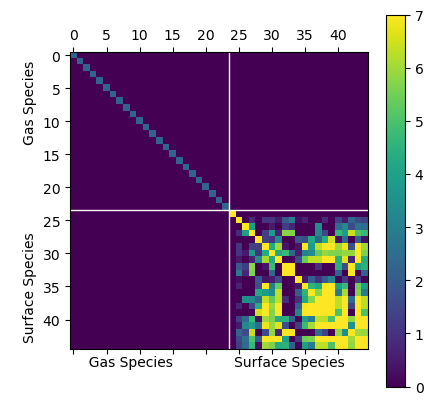

In [10]:
plt.matshow(cov_thermo)
plt.colorbar()
# plt.clim([-10, 50])

plt.clim([0, 7.0])


N_spec = len(uncertainty.species_list)
N_rxn = len(uncertainty.reaction_list)
N_total = N_spec + N_rxn

divider1 = np.argmax([x.contains_surface_site() for x in uncertainty.species_list]) - 0.5

plt.axvline(x=divider1, color='w', linewidth=1.0)
plt.axhline(y=divider1, color='w', linewidth=1.0)

plt.xlabel('                  Gas Species              Surface Species                   ')
plt.ylabel('Surface Species                    Gas Species')
# plt.axvline(x=divider, color='w', linestyle='dashed', linewidth=0.75, dashes=(7, 10))
# plt.axhline(y=divider, color='w', linestyle='dashed', linewidth=0.75, dashes=(7, 10))

In [11]:
# add cov after the fact

ads_corr_cov = np.load('ads_correction_covarance_kcal_mol2.npy')

db_ads_group_items = [uncertainty.database.thermo.groups['adsorptionPt111'].entries[key].item for key in uncertainty.database.thermo.groups['adsorptionPt111'].entries]

with open('my_ads_corr_list.pickle', 'rb') as f:
    data = pickle.load(f)
reconstructed_items = []
for i in range(len(data)):
    if i < len(db_ads_group_items):
        mol = rmgpy.molecule.Group().from_adjacency_list(data[i])
    else:
        mol = rmgpy.molecule.Molecule().from_adjacency_list(data[i])
        
    reconstructed_items.append(mol)
assert len(data) == len(reconstructed_items)

n_groups = np.sum([isinstance(mol, rmgpy.molecule.Group) for mol in reconstructed_items])
n_mols = np.sum([isinstance(mol, rmgpy.molecule.Molecule) for mol in reconstructed_items])
assert n_groups == len(db_ads_group_items)


assert len(reconstructed_items) == ads_corr_cov.shape[0]


In [33]:
list_of_molecules = [database.thermo.libraries['thermo_DFT_CCSDTF12_BAC'].entries[entry].item for entry in database.thermo.libraries['thermo_DFT_CCSDTF12_BAC'].entries]
list_of_thermodata = [database.thermo.libraries['thermo_DFT_CCSDTF12_BAC'].entries[entry].data for entry in database.thermo.libraries['thermo_DFT_CCSDTF12_BAC'].entries]






[ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([8.09,8.32,8.62,8.99,9.79,10.5,11.83],'cal/(mol*K)'), H298=(102.3,'kcal/mol'), S298=(45.19,'cal/(mol*K)')),
 ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([8.34,8.61,8.91,9.24,9.89,10.5,11.68],'cal/(mol*K)'), H298=(93.88,'kcal/mol'), S298=(46.64,'cal/(mol*K)')),
 ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([9.33,10.06,10.82,11.55,12.89,14.04,16.19],'cal/(mol*K)'), H298=(35.15,'kcal/mol'), S298=(46.48,'cal/(mol*K)')),
 ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([8.62,9.65,10.94,12.34,14.89,16.97,20.54],'cal/(mol*K)'), H298=(-17.76,'kcal/mol'), S298=(44.48,'cal/(mol*K)')),
 ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([6.95,6.95,6.95,6.97,7.08,7.25,7.72],'cal/(mol*K)'), H298=(8.76,'kcal/mol'), S298=(43.96,'cal/(mol*K)')),
 ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([8.04,8.18,8.38,8.62,9.2,9.77,11.02],'cal/(mol*K)'), H298=(-58

In [12]:
def get_i_thing(thing, thing_list):
    for i in range(len(thing_list)):
        if thing.is_isomorphic(thing_list[i]):
            return i
    return -1

In [13]:
def get_lib_covariance(sp1, sp2):
    i1 = get_i_thing(sp1, my_species)
    if i1 < 0:
        return 0
    i2 = get_i_thing(sp2, my_species)
    if i2 < 0:
        return 0
    
    # covariance of lib is given in (kJ/mol) ^2
    return lib_cov[i1, i2] / 4.184 / 4.814  # to convert to (kcal/mol) ^2

In [25]:
new_cov_matrix = copy.deepcopy(cov_thermo)

for i in range(len(uncertainty.species_list)):
    
    print(uncertainty.species_list[i].thermo.comment)
    
#     for j in range(i):
#         cov = get_covariance(uncertainty.species_list[i], uncertainty.species_list[j])
#         new_cov_matrix[i, j] += cov
#         new_cov_matrix[j, i] += cov

Thermo library: primaryThermoLibrary
Thermo library: primaryThermoLibrary
Thermo library: primaryThermoLibrary
Thermo library: primaryThermoLibrary
Thermo library: primaryThermoLibrary
Thermo library: thermo_DFT_CCSDTF12_BAC
Thermo library: primaryThermoLibrary
Thermo library: primaryThermoLibrary
Thermo library: primaryThermoLibrary
Thermo library: thermo_DFT_CCSDTF12_BAC
Thermo library: thermo_DFT_CCSDTF12_BAC
Thermo library: thermo_DFT_CCSDTF12_BAC
Thermo library: DFT_QCI_thermo
Thermo library: primaryThermoLibrary
Thermo library: thermo_DFT_CCSDTF12_BAC
Thermo library: thermo_DFT_CCSDTF12_BAC
Thermo library: thermo_DFT_CCSDTF12_BAC
Thermo library: DFT_QCI_thermo
Thermo library: primaryThermoLibrary
Thermo library: thermo_DFT_CCSDTF12_BAC
Thermo library: DFT_QCI_thermo
Thermo library: thermo_DFT_CCSDTF12_BAC
Thermo library: thermo_DFT_CCSDTF12_BAC
Thermo library: thermo_DFT_CCSDTF12_BAC
Thermo library: surfaceThermoPt111
Thermo library: surfaceThermoPt111
Thermo library: surfaceTher

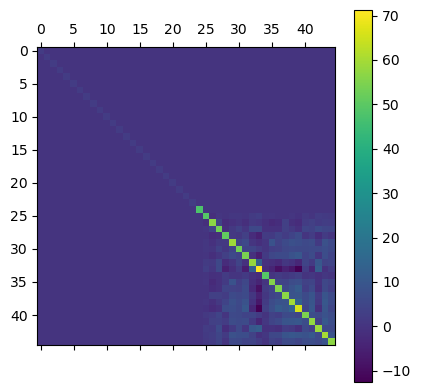

In [26]:
plt.matshow(new_cov_matrix)
plt.colorbar()
# plt.clim([-40, 40])

In [27]:
other_cov = copy.deepcopy(new_cov_matrix)
for i in range(other_cov.shape[0]):
    other_cov[i, i]=0


In [30]:
new_cov_matrix[32, 32]

57.91457342082106

In [22]:
for i in range(len(uncertainty.species_list)):
    if uncertainty.species_list[i].contains_surface_site():
        covs = other_cov[i, :]
        j = np.argmax(covs)
        print(other_cov[i,j], '\t', uncertainty.species_list[i], '\t', uncertainty.species_list[j])

0.0 	 X(1) 	 Ar
2.934735405133575 	 HX(21) 	 CX(29)
3.966904354438617 	 CO2X(22) 	 COX(23)
6.447244341066336 	 COX(23) 	 OC#[Pt](61)
6.534697794288464 	 CH4X(24) 	 CO.[Pt](49)
8.49020559811778 	 OX(25) 	 OHX(31)
7.210558988846813 	 CH2X(26) 	 OC=[Pt](62)
10.111591913278756 	 CH3X(27) 	 CO.[Pt](49)
12.993278437570329 	 CHX(28) 	 CX(29)
12.993278437570329 	 CX(29) 	 CHX(28)
3.183057356414201 	 H2X(30) 	 CO.[Pt](49)
8.49020559811778 	 OHX(31) 	 OX(25)
11.611261671130107 	 H2OX(32) 	 CO.[Pt](49)
9.563613966570989 	 CHOX(33) 	 CO.[Pt](49)
13.644985826692682 	 OC[Pt](48) 	 CO.[Pt](49)
13.644985826692682 	 CO.[Pt](49) 	 OC[Pt](48)
8.68495025074818 	 CHOX2(52) 	 OC=[Pt](62)
10.424731892446585 	 O=C(O)[Pt](60) 	 OC=[Pt](62)
12.187482707662811 	 OC#[Pt](61) 	 CX(29)
10.424731892446585 	 OC=[Pt](62) 	 O=C(O)[Pt](60)
8.68495025074818 	 CHO2X2(72) 	 OC=[Pt](62)


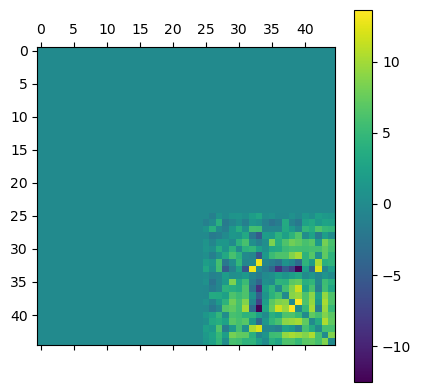

In [17]:
plt.matshow(other_cov)
plt.colorbar()

In [ ]:
uncertainty.thermo_covariance_matrix = new_cov_matrix

In [ ]:
uncertainty.get_kinetic_covariance_matrix()

In [ ]:
plt.matshow(uncertainty.kinetic_covariance_matrix)
plt.colorbar()

In [ ]:
plt.matshow(uncertainty.get_overall_covariance_matrix())
plt.colorbar()

In [ ]:
M = new_cov_matrix.shape[0]
N = uncertainty.kinetic_covariance_matrix.shape[0]


overall_uncertainty = np.zeros((M + N, M + N))
overall_uncertainty[:M, :M] = new_cov_matrix
overall_uncertainty[M:, M:] = uncertainty.kinetic_covariance_matrix

In [ ]:
np.save('overall_uncertainty_kcal2mol2.npy', overall_uncertainty)

In [ ]:
plt.matshow(overall_uncertainty)
plt.colorbar()

In [ ]:
np.save('cpox_sampling_thermo_cov_kcal2mol2.npy', new_cov_matrix)

In [ ]:
for i in range(len(uncertainty.species_list)):
    print(i, uncertainty.species_sources_dict[uncertainty.species_list[i]])

In [ ]:
uncertainty.species_list[40].thermo.comment

In [ ]:
'ADS' in uncertainty.species_sources_dict[uncertainty.species_list[44]]

In [ ]:
uncertainty.species_sources_dict[uncertainty.species_list[44]]['ADS']['adsorptionPt111'][0][0].item

In [ ]:
max_cov = 0
best_index = [-1, -1]
for i in range(new_cov_matrix.shape[0]):
    for j in range(i):
        if abs(new_cov_matrix[i, j]) > max_cov:
            max_cov = abs(new_cov_matrix[i, j])
            best_index = [i, j]

In [ ]:
np.sqrt(new_cov_matrix[39, 38])

In [ ]:
best_index

In [ ]:
plt.matshow(lib_cov / 4.184 / 4.814)
plt.colorbar()
plt.clim([-50, 50])

In [ ]:
uncertainty.species_list[24]